In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Dataset/Pepper",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 2475 files belonging to 2 classes.


In [4]:
for image_batch, labels_batch in dataset.take(3):
    print(image_batch.shape)
    print(labels_batch)

(32, 256, 256, 3)
tf.Tensor([0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1], shape=(32,), dtype=int32)
(32, 256, 256, 3)
tf.Tensor([0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1], shape=(32,), dtype=int32)
(32, 256, 256, 3)
tf.Tensor([0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1], shape=(32,), dtype=int32)


2025-01-31 15:16:57.406941: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-01-31 15:16:57.904829: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


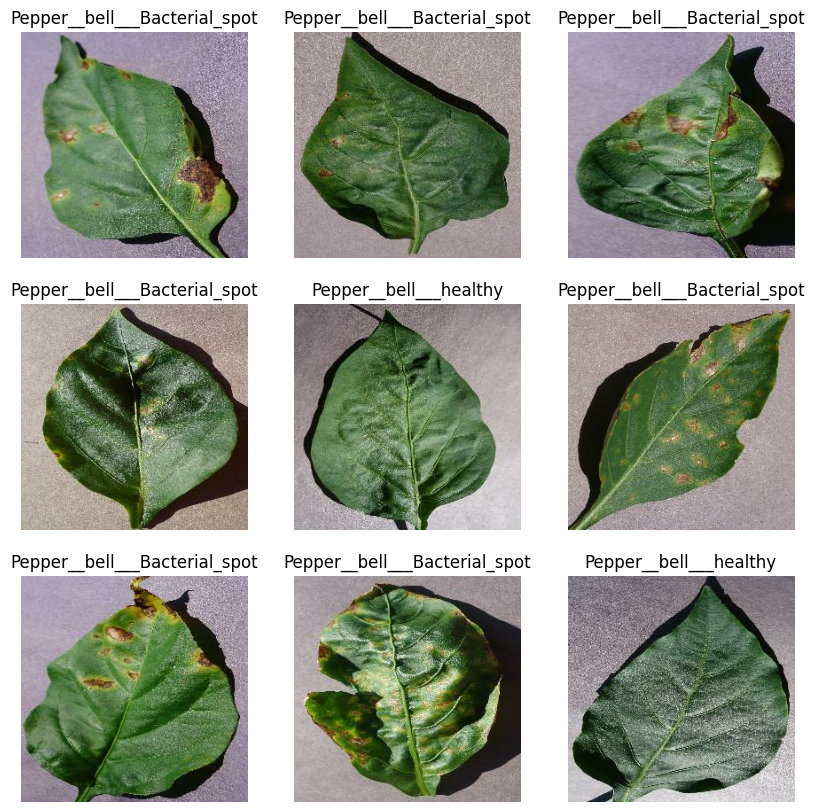

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[int(labels_batch[i])])
        plt.axis("off")

In [6]:
def getTrainValTest(
    dataset, train_percent, val_percent, test_percent, shuffle=True, shuffle_size=10000
):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, reshuffle_each_iteration=False)

    train_size = int(len(dataset) * train_percent)
    val_size = int(len(dataset) * val_percent)
    test_size = int(len(dataset) * test_percent)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = getTrainValTest(dataset, 0.7, 0.15, 0.15)

In [8]:
train_dataset = (
    train_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
val_dataset = (
    val_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
test_dataset = (
    test_dataset.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [9]:
resize_and_rescale = tf.keras.Sequential(
    [layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), layers.Rescaling(1.0 / 255)]
)

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), input_shape=input_shape, activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

model.build(input_shape)

/Users/rubaet/Downloads/PlanAid-Server-main/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,258 (3.42 MB)

 Trainable params: 896,258 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [14]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 650ms/step - accuracy: 0.6114 - loss: 0.6798 - val_accuracy: 0.6051 - val_loss: 0.5864
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 651ms/step - accuracy: 0.8770 - loss: 0.3796 - val_accuracy: 0.7585 - val_loss: 1.1357
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 677ms/step - accuracy: 0.8990 - loss: 0.2838 - val_accuracy: 0.6080 - val_loss: 3.3660
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 678ms/step - accuracy: 0.9119 - loss: 0.2786 - val_accuracy: 0.9688 - val_loss: 0.1278
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 720ms/step - accuracy: 0.9655 - loss: 0.1118 - val_accuracy: 0.9659 - val_loss: 0.0817
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9661 - loss: 0.0910 - val_accuracy: 0.9830 - val_loss: 0.0665
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 793ms/step - accuracy: 0.9872 - loss: 0.0422 - val_accuracy: 0.9801 - val_loss: 0.1166
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 774ms/step - accuracy: 0.9809 - loss: 0.0602 - val_accurac

In [15]:
scores = model.evaluate(test_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9990 - loss: 0.0042


In [16]:
scores

[0.007551470305770636, 0.9971590638160706]

In [17]:
history

In [18]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
acc = history.history["accuracy"]
loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation accuracy')

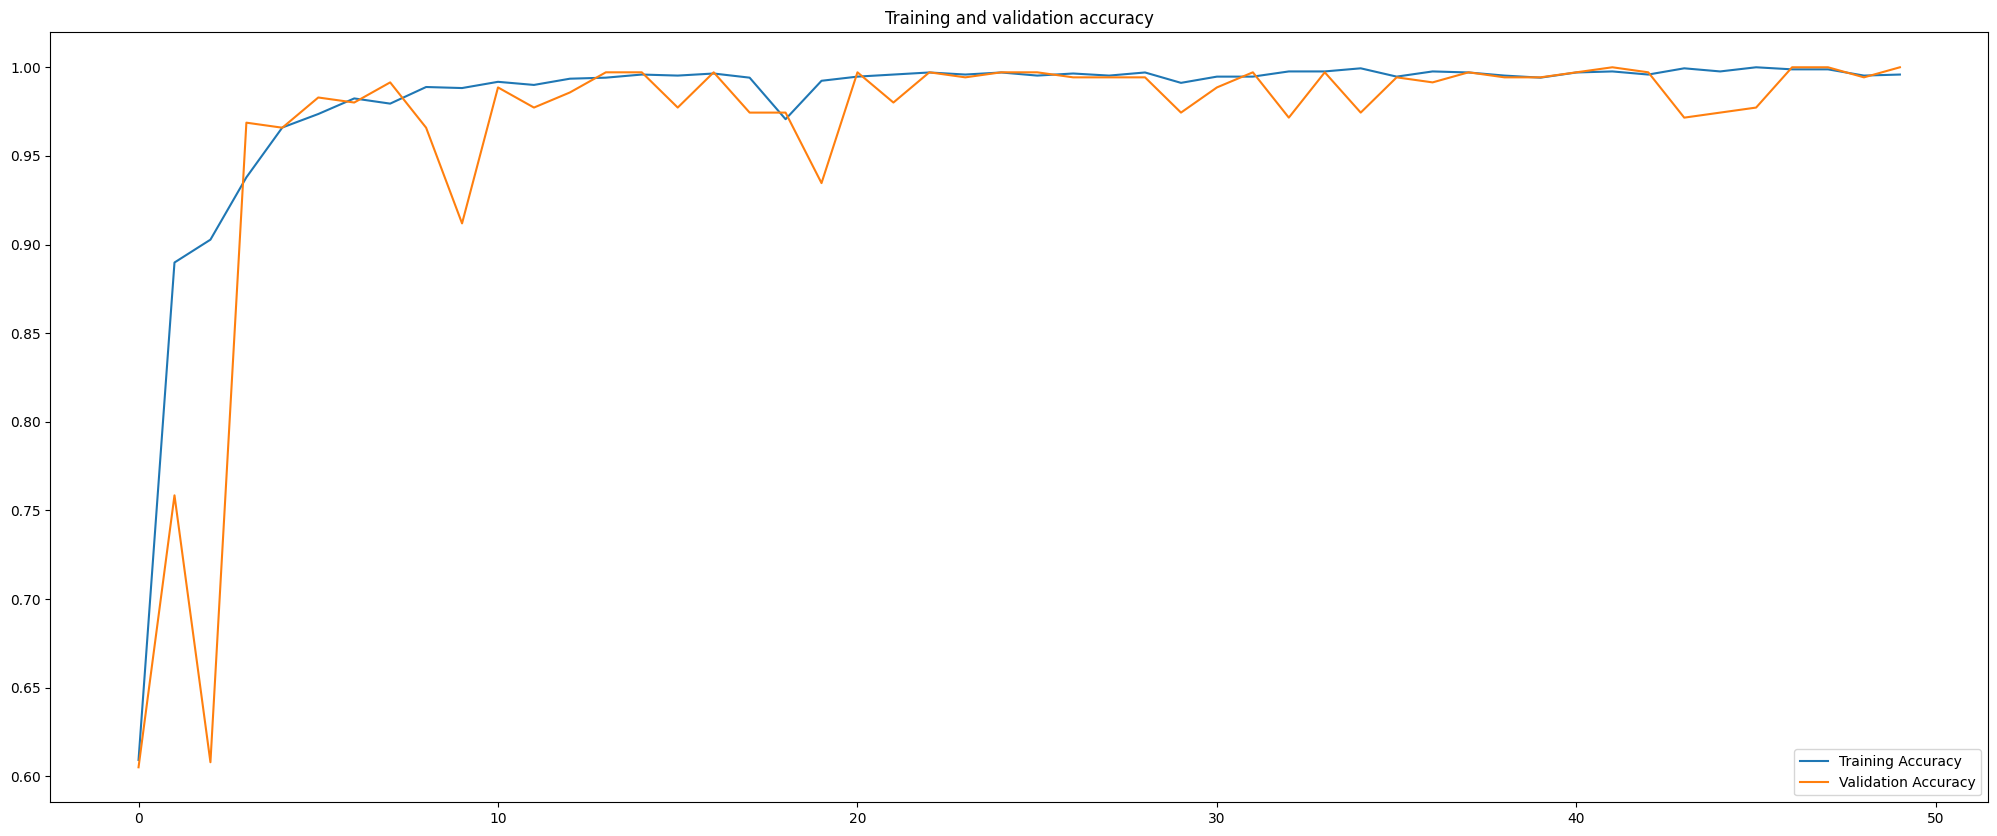

In [21]:
plt.figure(figsize=(25, 10))
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

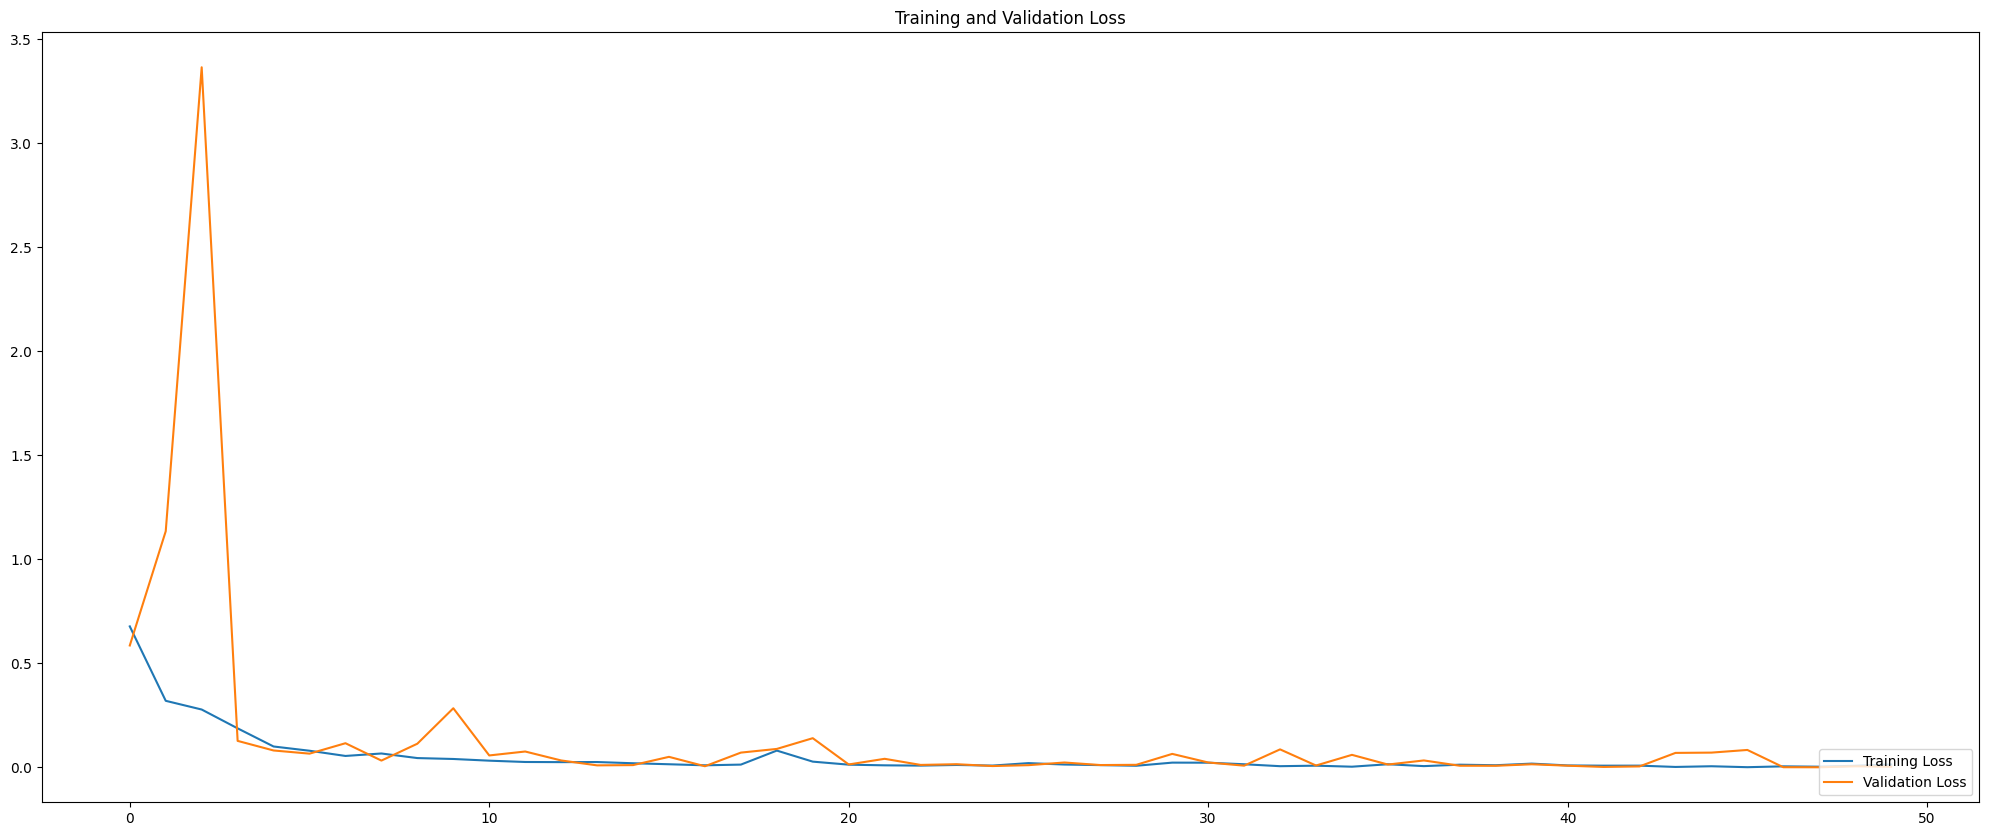

In [22]:
plt.figure(figsize=(25, 10))
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

First Image to predict
Actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted label: Pepper__bell___Bacterial_spot


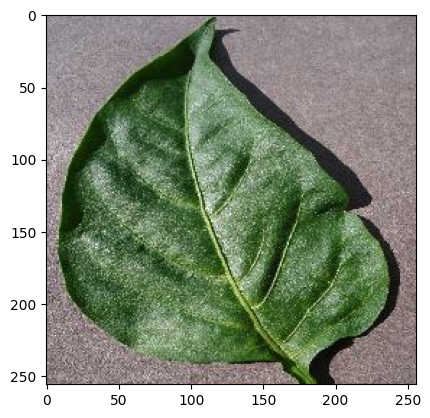

In [23]:
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[20].numpy().astype("uint8")
    first_label = labels_batch[20].numpy()
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual label:", dataset.class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", dataset.class_names[batch_prediction[0].argmax()])


In [24]:
def predic_img(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = dataset.class_names[predictions[0].argmax()]
    confidence = predictions[0][predictions[0].argmax()]
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2025-01-31 15:57:26.910212: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


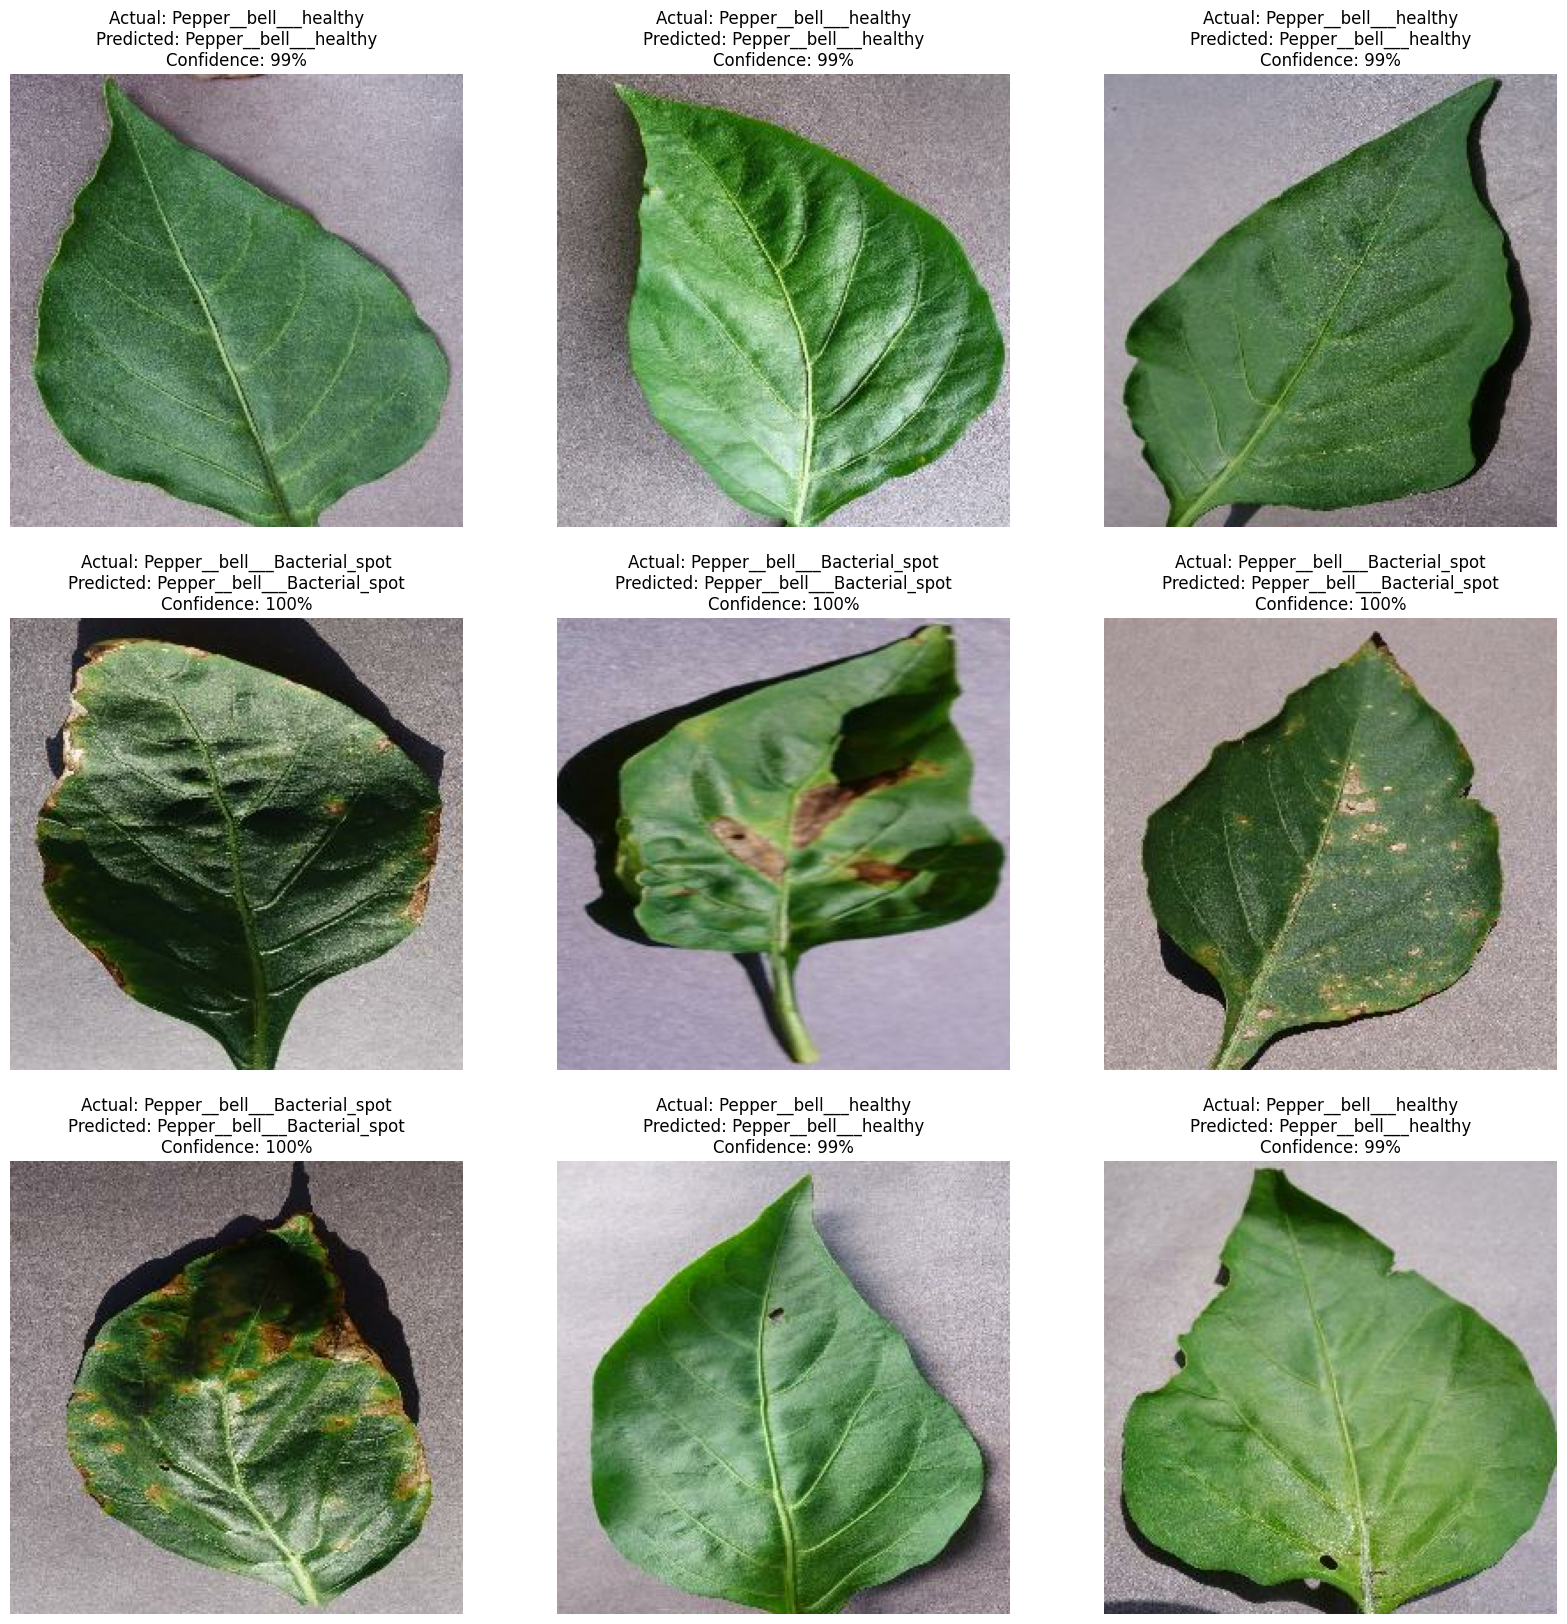

In [25]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
    for i in range(9):
        predicted_class, confidence = predic_img(model, images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = dataset.class_names[labels[i]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_class}\nConfidence: {int(confidence * 100)}%")
        plt.axis("off")

In [27]:
import os
model_name = "pepper"

versions = os.listdir(f"../models/{model_name}")
versions = [int(v) for v in versions if v.isdigit()]
model_version = max(versions) + 1 if versions else 1
model_version = str(model_version)
model_dir = f"../models/{model_name}/{model_version}"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/model.keras")

In [1]:
import tensorflow as tf
from tensorflow.keras import models
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tf2onnx
import onnxruntime as rt

model_name = "pepper"
versions = os.listdir(f"../models/{model_name}")
model_version = max(versions) if versions else 1

model_path = f"../models/{model_name}/{model_version}/model.keras"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    print(f"Model file not found at {model_path}")

print(model.input_shape)

spec = (tf.TensorSpec(model.input_shape, tf.float32, name="input"),)

output_path = f"../models/{model_name}/{model_version}/{model.name}.onnx"
model.output_names = ["output"]
model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature=spec, opset=13, output_path=output_path
)



(32, 256, 256, 3)
